#### This notebook is a merge of few Kaggle Notebooks from the Kaggle competitions mentioned below:
- https://www.kaggle.com/qitvision/a-complete-ml-pipeline-fast-ai
- https://www.kaggle.com/suicaokhoailang/wip-densenet121-baseline-with-fastai
- https://www.kaggle.com/sanchit2843/pytorchdensenet201
- https://www.kaggle.com/sdeagggg/densenet121-with-fast-ai-v1



### Plot some images with and without cancer tissue for comparison

In [3]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

In [5]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 90          # final size after crop
RANDOM_ROTATION = 3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 7  # range (0-100), 0=no change
RANDOM_CONTRAST = 5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 1  # 0 or 1= random turn to left or right

def readCroppedImage(path, augmentations = True):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    
    return rgb_img

Text(0, 0.5, 'Tumor tissue samples')

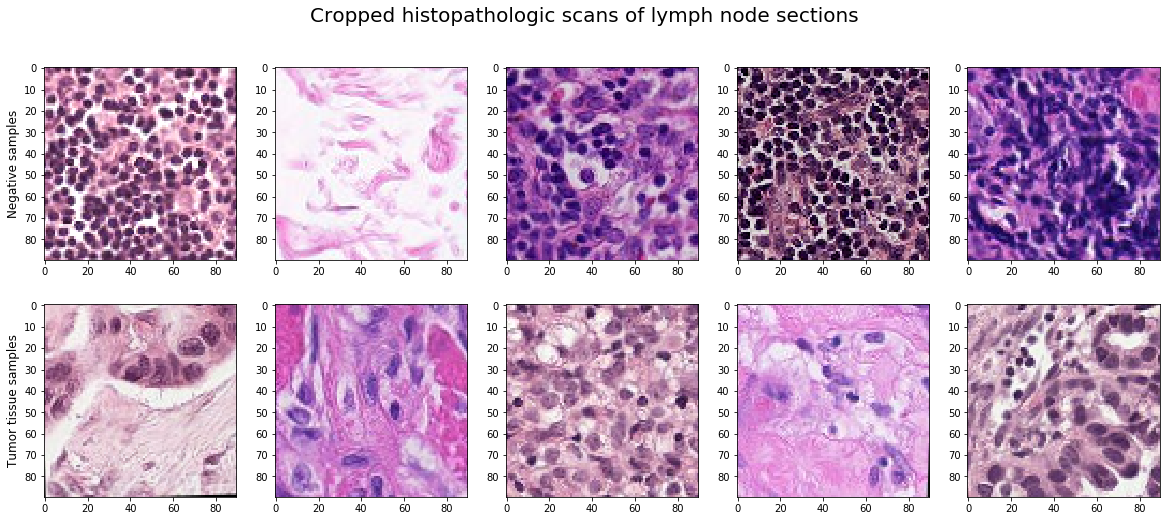

In [6]:
fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Cropped histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readCroppedImage(path + '.tif'))
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readCroppedImage(path + '.tif'))
ax[1,0].set_ylabel('Tumor tissue samples', size='large')

**To see the effects of our augmentation, we can plot one image multiple times.**

# Baseline model (Fastai v1)
In ML production pipeline, it is a good idea to start with a relatively simple model, sort of a minimum viable product (MVP) or a baseline. With MVP, we can very quickly see if there are some unexpected problems like bad data quality that will make any further investments into the model tuning not worth it.

In [8]:
from sklearn.model_selection import train_test_split

# we read the csv file earlier to pandas dataframe, now we set index to id so we can perform
train_df = data.set_index('id')

#If removing outliers, uncomment the four lines below
#print('Before removing outliers we had {0} training samples.'.format(train_df.shape[0]))
#train_df = train_df.drop(labels=too_dark_idx, axis=0)
#train_df = train_df.drop(labels=too_bright_idx, axis=0)
#print('After removing outliers we have {0} training samples.'.format(train_df.shape[0]))

train_names = train_df.index.values
train_labels = np.asarray(train_df['label'].values)

# split, this function returns more than we need as we only need the validation indexes for fastai
tr_n, tr_idx, val_n, val_idx = train_test_split(train_names, range(len(train_names)), test_size=0.1, stratify=train_labels, random_state=123)

We will use [**Fast.ai V1**](https://docs.fast.ai/) software library that is built on [PyTorch](https://pytorch.org/). What I like about Fast.ai is that it includes "out of the box" support for many recent advancements in deep learning research. If you want to use the 0.7 version of Fast.ai, see commit version 9 of this kernel.

I highly recommend the [Fastai: practical deep learning course for coders, v3](https://course.fast.ai/).

I want to thank [Martijn](https://www.kaggle.com/etinuz) for sharing his examples of Fastai v1 training and visualization! They were helpful when converting this kernel from Fastai v0.7 to v1.0.

### What kind of model architecture suits the problem best?

Here we will be using a pretrained convnet model and transfer learning to adjust the weights to our data. Going for a deeper model architecture will start overfitting faster.

For differenet pretrained model architectures, check [Fast.ai vision models](https://docs.fast.ai/vision.models.html) and [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
# fastai 1.0
from fastai import *
from fastai.vision import *
from torchvision.models import *    # import *=all the models from torchvision  

arch = densenet169                  # specify model architecture, densenet169 seems to perform well for this data but you could experiment
BATCH_SIZE = 128                    # specify batch size, hardware restrics this one. Large batch sizes may run out of GPU memory
sz = CROP_SIZE                      # input size is the crop size
MODEL_PATH = str(arch).split()[1]   # this will extrat the model name as the model file name e.g. 'resnet50'

We load the images to an ImageDataBunch for the training. This fastai's data object is easily customized for loading images using our own `readCroppedImage` function. We just need to subclass ImageList. 
[Data API docs](https://docs.fast.ai/data_block.html)

In [10]:
# create dataframe for the fastai loader
train_dict = {'name': train_path + train_names, 'label': train_labels}
df = pd.DataFrame(data=train_dict)
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + f)
df_test = pd.DataFrame(np.asarray(test_names), columns=['name'])

In [13]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = readCroppedImage(fn.replace('/./','').replace('\\',''))
        # This ndarray image has to be converted to tensor before passing on as fastai Image, we can use pil2tensor
        return vision.Image(px=pil2tensor(img, np.float32))
    

In [14]:
# Create ImageDataBunch using fastai data block API
imgDataBunch = (MyImageItemList.from_df(path='/', df=df, suffix='.tif')
        #Where to find the data?
        .split_by_idx(val_idx)
        #How to split in train/valid?
        .label_from_df(cols='label')
        #Where are the labels?
        .add_test(MyImageItemList.from_df(path='/', df=df_test))
        #dataframe pointing to the test set?
        .transform(tfms=[[],[]], size=sz)
        # We have our custom transformations implemented in the image loader but we could apply transformations also here
        # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
        .databunch(bs=BATCH_SIZE)
        # convert to databunch
        .normalize([tensor([0.702447, 0.546243, 0.696453]), tensor([0.238893, 0.282094, 0.216251])])
        # Normalize with training set stats. These are means and std's of each three channel and we calculated these previously in the stats step.
       )

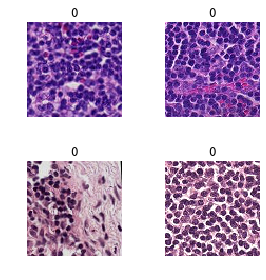

In [15]:
# check that the imgDataBunch is loading our images ok
imgDataBunch.show_batch(rows=2, figsize=(4,4))

### Training
We define a convnet learner object where we set the model architecture and our data bunch.
[`create_cnn` docs.fast.ai](https://docs.fast.ai/vision.learner.html#create_cnn)

In [17]:
# Next, we create a convnet learner object
# ps = dropout percentage (0-1) in the final layer
def getLearner():
    return cnn_learner(imgDataBunch, arch, pretrained=True, path='.', metrics=accuracy, ps=0.5, callback_fns=ShowGraph)

learner = getLearner()

epoch,train_loss,valid_loss,accuracy,time
1,0.225564,0.330577,0.859792,07:33
2,0.215519,0.258005,0.924783,07:31


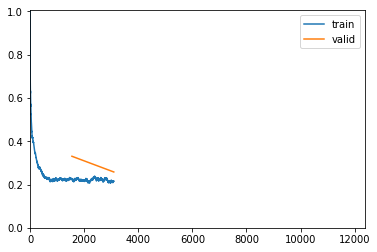

In [19]:
max_lr = 2e-2
wd = 1e-4
# 1cycle policy
learner.fit_one_cycle(cyc_len=8, max_lr=max_lr, wd=wd)

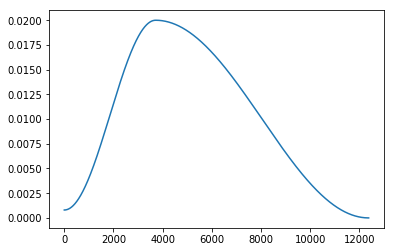

In [20]:
# plot learning rate of the one cycle
learner.recorder.plot_lr()

We can see that the learning rate starts from lower and reaches the `max_lr` in the middle. Then it slows back down near the end. The idea is that we start with a low warm-up learning rate and gradually increase it to high. The higher rate is having a regularizing effect as it won't allow the model to settle for sharp and narrow local minima but pushes for wider and more stable one.

In the middle of our cycle, we start to lower the learning rate as we are hopefully in a good stable area. This means that we start to look for the minima within that area.

## Is the model learning?
Our model should have already learned something and if it hasn't, there's probably something wrong with our code or with the data. 

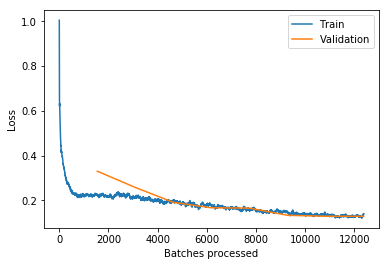

In [21]:
# and plot the losses of the first cycle
learner.recorder.plot_losses()

We can see from the plotted losses that there is a small rise after the initial drop which is caused by the increasing learning rate of the first half cycle. The losses are temporarily rising when `max_lr` drives the model out of local minima but this will pay off in the end when the learning rates are decreased.

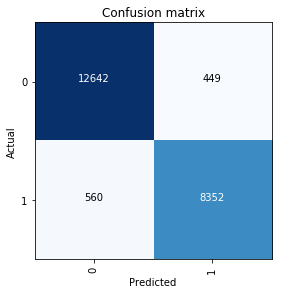

In [22]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

**Confusion matrix** can help us understand the ratio of false negatives and positives and it's a fast way looking at our model's performance. This is a simple table that shows the counts in a way of actual label vs. predicted label. Here we can see that the model has learned to distinguish tumor and negative sample and it's already performing well. However, we will continue training further to improve from here.

In [23]:
# before we continue, lets save the model at this stage
learner.save(MODEL_PATH + '_stage1')

# Finetuning the baseline model
Next, we can unfreeze all the trainable parameters from the model and continue its training. 

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


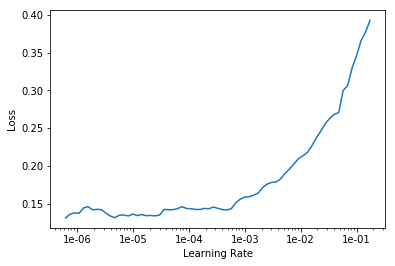

In [24]:
# load the baseline model
learner.load(MODEL_PATH + '_stage1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
1,0.135752,0.131022,0.951825,08:00
2,0.131664,0.133745,0.950734,08:03


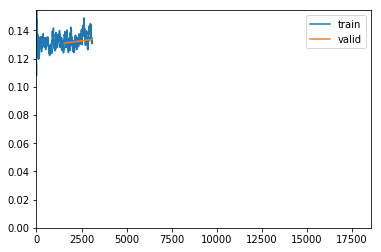

In [25]:
# Now, smaller learning rates. This time we define the min and max lr of the cycle
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

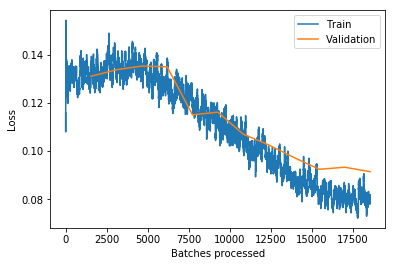

In [26]:
learner.recorder.plot_losses()

We can see that the validation performance has separated from the training performance a bit in the end of the cycle. This means that our model has started overfitting during the small learning rates. Now, if we would train further, the model would only memorize features from the training set and the validation set performance would rise. This is a good place to stop.  

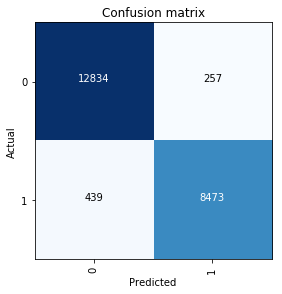

In [27]:
# lets take a second look at the confusion matrix. See if how much we improved.
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix(title='Confusion matrix')

In [28]:
# Save the finetuned model
learner.save(MODEL_PATH + '_stage2')

In [29]:
# if the model was better before finetuning, uncomment this to load the previous stage
#learner.load(MODEL_PATH + '_stage1')

-------------------------
# Validation and analysis
Now the training is done.

### How good does the model perform technically?

We can only get metrics from our validation set, and the final test metrics will be most likely a bit different.

In [30]:
preds,y, loss = learner.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9672771692276001 %.


### How good is the model in terms of project requirements?
It is a good idea to look at examples of images from:

- Random samples
    - Some random predictions
- The most incorrectly labeled
    - What our model predicts wrong with very high probability.
- The most correctly labeled
    - What our model is most confident of and gets right.
    
This visualization is a good way of understanding what are the images the model struggles with. It might also reveal something about the dataset such as bad quality data.

In [31]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

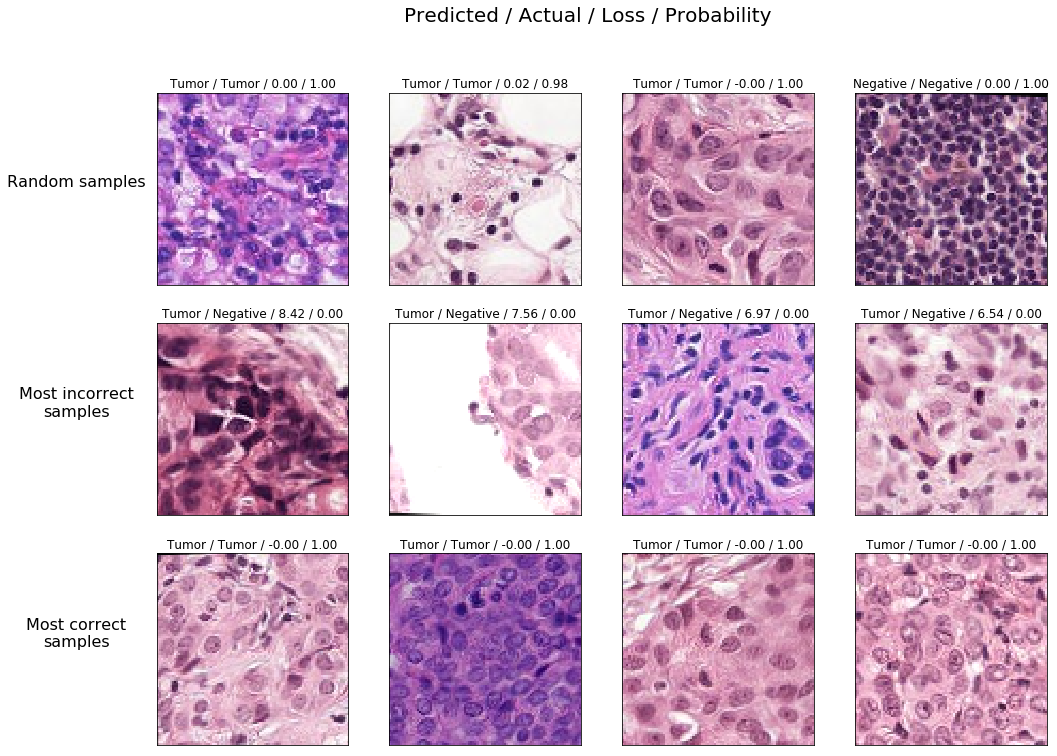

In [32]:
#interp = ClassificationInterpretation.from_learner(learner)
plot_overview(interp, ['Negative','Tumor'])

### ROC curve and AUC
Remember, AUC is the metric that is used for evaluating submissions. We can calculate it here for ou validation set but it will most likely differ from the final score.

In [37]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9940965007480436


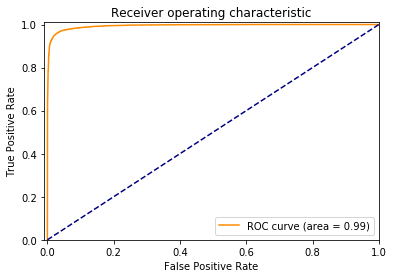

In [38]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

----------------

# Submit predictions
### TTA
To evaluate the model, we run inference on all test images. As we have test time augmentation, our results will probably improve if we do predictions multiple times per image and average out the results. 

In [39]:
# make sure we have the best performing model stage loaded
learner.load(MODEL_PATH + '_stage2')

# Fastai has a function for this but we don't want the additional augmentations it does (our image loader has augmentations) so we just use the get_preds
#preds_test,y_test=learner.TTA(ds_type=DatasetType.Test)

# We do a fair number of iterations to cover different combinations of flips and rotations.
# The predictions are then averaged.
n_aug = 12
preds_n_avg = np.zeros((len(learner.data.test_ds.items),2))
for n in tqdm_notebook(range(n_aug), 'Running TTA...'):
    preds,y = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)
    preds_n_avg = np.sum([preds_n_avg, preds.numpy()], axis=0)
preds_n_avg = preds_n_avg / n_aug

In [40]:
# Next, we will transform class probabilities to just tumor class probabilities
print('Negative and Tumor Probabilities: ' + str(preds_n_avg[0]))
tumor_preds = preds_n_avg[:, 1]
print('Tumor probability: ' + str(tumor_preds[0]))
# If we wanted to get the predicted class, argmax would get the index of the max
class_preds = np.argmax(preds_n_avg, axis=1)
classes = ['Negative','Tumor']
print('Class prediction: ' + classes[class_preds[0]])

Negative and Tumor Probabilities: [9.996547e-01 3.452967e-04]
Tumor probability: 0.0003452967397000369
Class prediction: Negative


### Submit the model for evaluation
We need to submit the tumor probability for each test sample in this competition. The probability ranges from 0 to 1.

In [41]:
# get test id's from the sample_submission.csv and keep their original order
SAMPLE_SUB = '/kaggle/input/sample_submission.csv'
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.id)

# List of tumor preds. 
# These are in the order of our test dataset and not necessarily in the same order as in sample_submission
pred_list = [p for p in tumor_preds]

# To know the id's, we create a dict of id:pred
pred_dic = dict((key, value) for (key, value) in zip(learner.data.test_ds.items, pred_list))

# Now, we can create a new list with the same order as in sample_submission
pred_list_cor = [pred_dic['///kaggle/input/test/' + id + '.tif'] for id in sample_list]

# Next, a Pandas dataframe with id and label columns.
df_sub = pd.DataFrame({'id':sample_list,'label':pred_list_cor})

# Export to csv
df_sub.to_csv('{0}_submission.csv'.format(MODEL_PATH), header=True, index=False)

In [42]:
# This is what the first 10 items of submission look like
df_sub.head(10)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.001230
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.015696
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.000555
3,2c35657e312966e9294eac6841726ff3a748febf,0.001031
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.004752
5,725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0.991448
6,aa0307865281d4484ddf8c637c348292968b93a7,0.318559
7,f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0.050692
8,95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0.000603
9,ee1f5345a8d4e28403b7e61b97b5f76c201ce9cb,0.001494
